# Spaceship Titanic

This notebook analyses the Spaceship Titanic data

- https://www.kaggle.com/competitions/playground-series-s4e10/data


# Step 0: Imports

In [52]:
#--------------------
# General
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format
#--------------------

#--------------------
# Category Encoder
import category_encoders as ce
#--------------------

#--------------------
# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------

#--------------------
# Models
# XGBoost
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier
#--------------------

#--------------------
# SHAP Explainability
import shap
shap.initjs()
#--------------------

#--------------------
# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#--------------------

#--------------------
# Gini by split
def gini_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate Gini for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        values.append(roc_auc_score(y_true=this_y_true, y_score=this_y_score)*2-1)
    return pd.DataFrame({'group':levels, 'Gini':values}).round(round)
#--------------------

#--------------------
# ROC Curve
def roc_curve_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate ROC Curve for each group
    """
    levels=group.unique()
    prep_auc=pd.DataFrame()
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        fpr, tpr, _= roc_curve(y_true=this_y_true, y_score=this_y_score)
        t1=pd.DataFrame({'Model': this_level, 'fpr': fpr, 'tpr': tpr})
        prep_auc=pd.concat([prep_auc, t1], axis=0)
    return prep_auc.round(round)
#--------------------

# Step 1: Load Data

In [53]:
# Load Data
df=pd.read_csv("train.csv").drop(columns=['PassengerId'])

# Split Cabin into Deck, Num, Side
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
df['Num']=df['Num'].astype(float)

# Copy data
df2=copy.deepcopy(df)

# Convert Transported to 0 and 1
df2['Transported']=df2['Transported'].astype(int)

# Drop unwanted features
df2.drop(columns=['Name', 'Cabin'], inplace=True)

# Impute missing values for categoriacl features
categorical_cols = df2.select_dtypes(exclude=[np.number]).columns
df2[categorical_cols] = df2[categorical_cols].fillna('MISSING')

# Impute missing values for numeric features
numeric_cols = df2.select_dtypes(include=[np.number]).columns
df2[numeric_cols] = df2[numeric_cols].fillna(df2[numeric_cols].median())

# Sparse categorical features
mask=df2['Deck'].isin(['MISSING', 'T'])
df2['Deck']=np.where(mask, 'MISSING_T', df2['Deck'])


# Step 2: Plot Data

### Response

### Numerical Features 

### Categorical Featues 

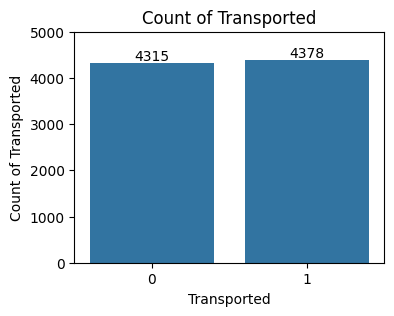

---------------
Population Transported Rate
0.503624
---------------


In [54]:
# Plot Response

# Summarise for the plot
df_smry=df2['Transported'].value_counts().reset_index()

# Response plot
plt.figure(figsize=(4,3))
ax=sns.barplot(df_smry, x='Transported', y='count')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Transported')
ax.set_ylabel('Count of Transported')
plt.ylim(0, 5000) 
plt.title('Count of Transported')
plt.show()

# Population default rate
print('---------------')
print('Population Transported Rate')
print(df['Transported'].mean().round(6))
print('---------------')

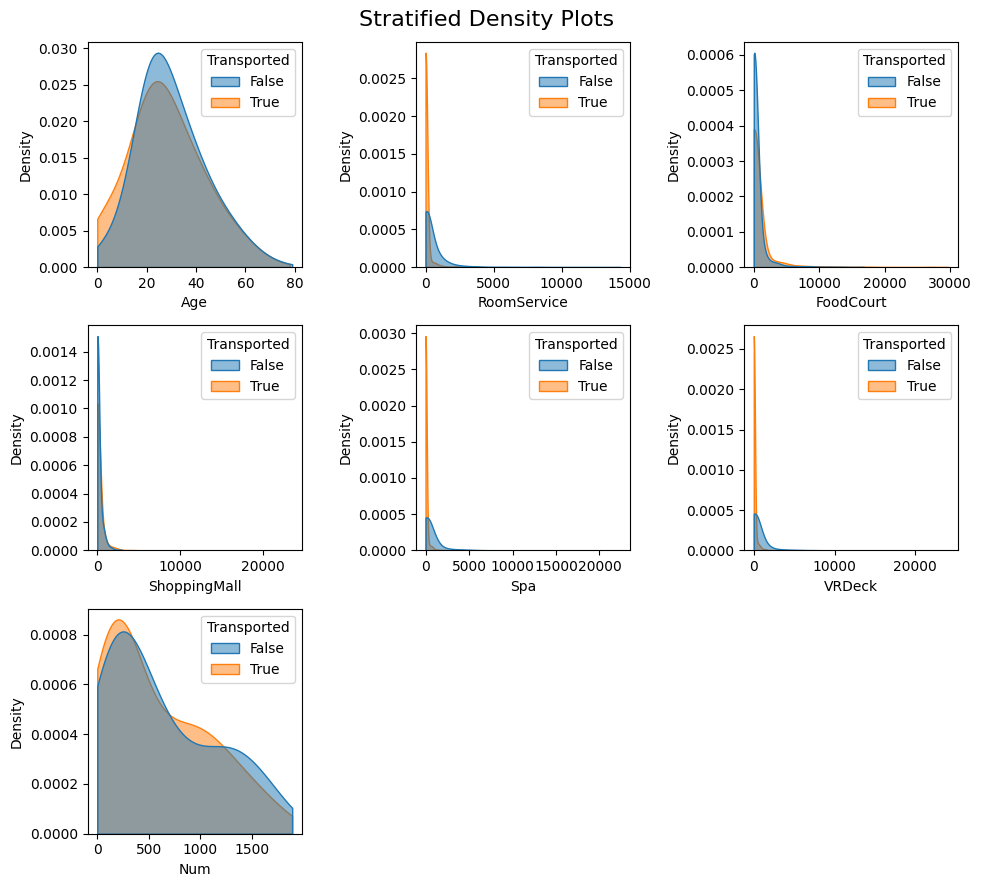

In [55]:
# Plot Numeric Features

# Numeric Features
numeric_cols = df2.select_dtypes(include=[np.number]).columns.drop('Transported')
num_numeric_cols=len(numeric_cols)

# Set up grid dimensions
cols = 3
rows = (num_numeric_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# KDE Plots
for i, this_var in enumerate(numeric_cols):
    sns.kdeplot(data=df, 
                x=this_var, 
                hue='Transported', 
                fill=True, 
                common_norm=False,
                cut=0,
                alpha=0.5,
                bw_adjust=2.5,
                ax=axes[i])
fig.suptitle('Stratified Density Plots', fontsize=16)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

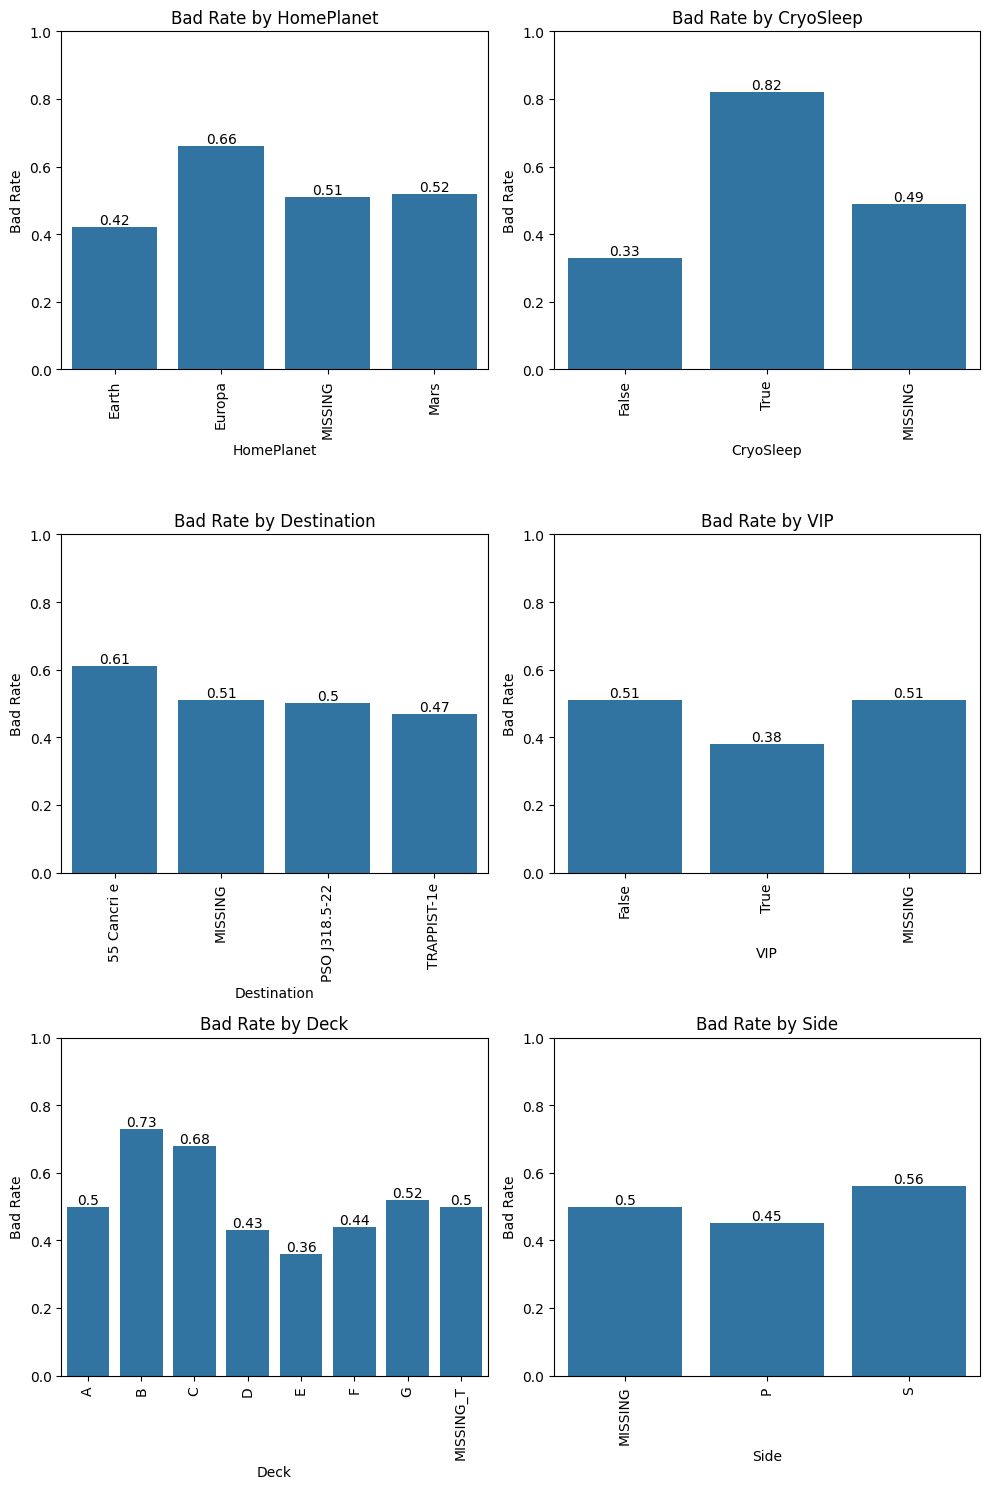

In [56]:
# Plot Categorical Features

# Identify categorical columns
categorical_cols = df2.select_dtypes(exclude=[np.number]).columns
num_categorical_cols = len(categorical_cols)

# Set up grid dimensions
cols = 2
rows = (num_categorical_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(categorical_cols):
    df_smry = df2[['Transported', col]].groupby(col).mean().reset_index().round(2)

    ax = axes[i]  # Get the current axis
    sns.barplot(data=df_smry, x=col, y='Transported', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel(col)
    ax.set_ylabel('Bad Rate')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, 1)
    ax.set_title(f'Bad Rate by {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Step 3: Information Values

In [68]:
def woe_iv(feature=None, target=None, feature_name=None, num_binns=4):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for a given feature.
    
    Parameters:
        feature (pd.Series): The feature column for which WoE and IV need to be calculated.
        target (pd.Series): The target column (binary) against which IV is calculated.
        num_binns (int): Number of bins to divide the feature values (for numeric features).
    
    Returns:
        tuple: A tuple containing:
            - tbl (pd.DataFrame): Table with WoE and IV computations.
            - iv (float): The Information Value for the feature.
    """
    # Check if the feature is numeric
    if np.issubdtype(feature.dtype, np.number):
        # Create bins based on quantiles for target = 1
        _, bins = pd.qcut(feature[target == 1], 
                          q=num_binns, 
                          retbins=True,
                          duplicates='drop')
        # Extend bin range for edge cases
        bins[0] = -999999999
        bins[-1] = 999999999
        # Bin the feature values
        binned = pd.cut(feature, bins=bins)
    else:
        # Use categorical feature as is
        binned = feature

    # Create a crosstab between binned feature and target
    tbl = pd.crosstab(index=binned, columns=target)
    # Calculate percentages for target=0 and target=1
    tbl['% 0'] = tbl[0] / sum(tbl[0])
    tbl['% 1'] = tbl[1] / sum(tbl[1])
    # Calculate Weight of Evidence (WoE)
    tbl['woe'] = np.log(tbl['% 0'] / tbl['% 1'])
    # Calculate IV component for each bin
    tbl['iv_comp'] = (tbl['% 0'] - tbl['% 1']) * tbl['woe']

    # Remove the name of the columns (if set, for cleaner output)
    tbl.columns.name = ''
    # Reset the index of the DataFrame to make the bins or levels part of the columns
    tbl.reset_index(inplace=True)
    # Add a new column to indicate the feature name
    tbl['feature'] = feature_name
    # Rename the feature column to 'level' for clarity
    tbl.rename(columns={feature_name: 'level'}, inplace=True)
    # Reorder the columns to place 'feature' as the first column
    order=[tbl.columns.to_list()[-1]] + tbl.columns.to_list()[0:-1]
    tbl=tbl[order]

    # Total Information Value (IV)
    iv = sum(tbl['iv_comp'])
    
    return tbl, iv

# Extract all features excluding the target column
all_features = df2.drop(columns='Transported').columns.to_list()
num_features = len(all_features)

# Loop through each feature to calculate IV
for i in range(0, num_features):
    if i==0:
        woe_results=pd.DataFrame();        
    
    this_feature = all_features[i]
    # Calculate IV for the current feature
    woe_tbl, _ = woe_iv(feature=df2[this_feature], 
                         target=df2['Transported'], 
                         feature_name=this_feature, 
                         num_binns=10)
    # Append the IV value to the results list
    woe_results=pd.concat([woe_results, woe_tbl])

woe_table=woe_results\
    .groupby('feature')['iv_comp']\
    .sum()\
    .reset_index()\
    .sort_values('iv_comp', ascending=False)\
    .reset_index(drop=True)

# Drop features with IV < 0.02
features_to_drop=woe_table\
    .query('iv_comp<0.02')['feature']\
    .to_list()

# Drop features
#df3=copy.deepcopy(df2.drop(columns=features_to_drop))
df3=copy.deepcopy(df2)

# Step 4: Sparse Categorical Values

In [88]:
# Copy dataset
df4=copy.deepcopy(df3)

# Tabuate Categorical  Features
cols=df4.select_dtypes(exclude=[np.number]).columns
for i in cols:
    tmp=pd.crosstab(index=df4[i], 
                    columns='Total', 
                    margins=True)
    tmp.columns.name=''
    print('---------------')
    print('### ', i, ' ###')
    display(tmp)
    print('---------------')
    print('')

# One-Hot Encoding
df5=copy.deepcopy(pd.get_dummies(df4, dtype='int'))
df5.columns=df5.columns.str.replace(' ', '_', regex=True)

---------------
###  HomePlanet  ###


,Total,All
HomePlanet,,
Earth,4602,4602
Europa,2131,2131
MISSING,201,201
Mars,1759,1759
All,8693,8693


---------------

---------------
###  CryoSleep  ###


,Total,All
CryoSleep,,
False,5439,5439
True,3037,3037
MISSING,217,217
All,8693,8693


---------------

---------------
###  Destination  ###


,Total,All
Destination,,
55 Cancri e,1800,1800
MISSING,182,182
PSO J318.5-22,796,796
TRAPPIST-1e,5915,5915
All,8693,8693


---------------

---------------
###  VIP  ###


,Total,All
VIP,,
False,8291,8291
True,199,199
MISSING,203,203
All,8693,8693


---------------

---------------
###  Deck  ###


,Total,All
Deck,,
A,256,256
B,779,779
C,747,747
D,478,478
E,876,876
F,2794,2794
G,2559,2559
MISSING_T,204,204
All,8693,8693


---------------

---------------
###  Side  ###


,Total,All
Side,,
MISSING,199,199
P,4206,4206
S,4288,4288
All,8693,8693


---------------



# Step 7: Prepare for Modelling

In [89]:
# X and y
X=df5.drop(columns='Transported')
y=df5['Transported']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8 Modeling

In [90]:
# Light GBM
mdl_lgb=LGBMClassifier(verbose=0, random_state=42)
mdl_lgb.fit(X_train, y_train)

# Predictions
mdl_lgb_train_pred=mdl_lgb.predict_proba(X_train)[:,1]
mdl_lgb_test_pred=mdl_lgb.predict_proba(X_test)[:,1]

train Gini:  0.94
test Gini:  0.79


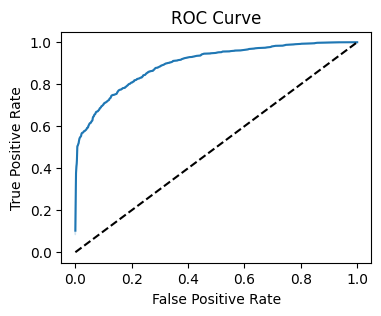

In [91]:
# Gini
print('train Gini: ', round(roc_auc_score(y_true=y_train, y_score=mdl_lgb_train_pred)*2-1,2))
print('test Gini: ',  round(roc_auc_score(y_true=y_test,  y_score=mdl_lgb_test_pred)*2-1, 2))


# ROC Curve
fpr, tpr, thresolds=roc_curve(y_true=y_test,  y_score=mdl_lgb_test_pred)
df_roc=pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresolds':thresolds})

# Plot ROC Curve
plt.figure(figsize=(4,3))
sns.lineplot(data=df_roc, x='fpr', y='tpr')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
